# Exploratory data analysis of California vineyards
The following notebook visualizes the data collected on vineyards vs non-vineyards to see if we can get clues on how to build the the most efficent & accurate predictive model.

## Import required packages and variables
We'll import the dataframe we created which contains elevation and weather data on the original addresses in our dataset 

In [242]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import datetime

#Make the default font size for plot labels larger than default
plt.rcParams.update({'font.size': 18})

#Open stored weather & elevation dataframe
with open('california_vineyards_elevation_weather.pkl', 'rb') as f: 
    elevation_weather_df = pickle.load(f)
    
#convert rows from a given column into a numpy array
def rows_to_2D_array(col):
    for i, row in enumerate(col):
        if i == 0:
            arr = ([row])
        else:
            arr = np.vstack([arr,row])
    return arr
    
#convert rows from a given column into a numpy array
def rows_to_3D_array(col):
    for i, row in enumerate(col):
        if i == 0:
            arr = np.array([row[0]])
        else:
            arr = np.concatenate([arr, np.array([row[0]])], axis=0)
    return arr

#Convert pandas columns into numpy array variables
is_vineyard = np.array(elevation_weather_df['IsVineyard']).astype(int)
map_coords = rows_to_2D_array(elevation_weather_df['MapCoords'])
elevation = rows_to_3D_array(elevation_weather_df['ElevationMatrix'])
wind_dir = rows_to_2D_array(elevation_weather_df['WindDir'])
wind_spd = rows_to_2D_array(elevation_weather_df['WindSpd'])
precip = rows_to_2D_array(elevation_weather_df['Precip'])
temp = rows_to_2D_array(elevation_weather_df['Temp'])
min_temp = rows_to_2D_array(elevation_weather_df['MinTemp'])
max_temp = rows_to_2D_array(elevation_weather_df['MaxTemp'])
clouds = rows_to_2D_array(elevation_weather_df['Clouds'])
ghi = rows_to_2D_array(elevation_weather_df['GHI'])
rh = rows_to_2D_array(elevation_weather_df['RH'])


#Replace missing values with mean of array
def replace_none(array):
    for subarray in array:
        subarray[subarray == None] = np.mean(subarray[subarray != None])
    
replace_none([map_coords, elevation, wind_dir, wind_spd, precip, temp, min_temp, max_temp, clouds, ghi, rh])

## Create color palette for plots

In [243]:
land_color =  'white' #''#fcfff2'
water_color = '#efefef'
vineyard_color = '#ff4116'
zillow_color = '#008cea'

#Setup custom legend to label scatterplot
vineyard_patch = mpatches.Patch(color=vineyard_color, label='Vineyard')
zillow_patch = mpatches.Patch(color=zillow_color, label='Zillow land')

## Map the addresses in our data set
Below is a color-coded map of vineyards vs non-vineyards in our data set overlaid on top of a map of California. 

One (unsurprising) insight from this plot is that many vineyards are clustered close to each other. Because of this, I built my model with and without map coordindates to ensure that it wasn't overfitting (aka cheating) by relying on the location data. Fortunately, I found that the model performed nearly the same with / without that variable.

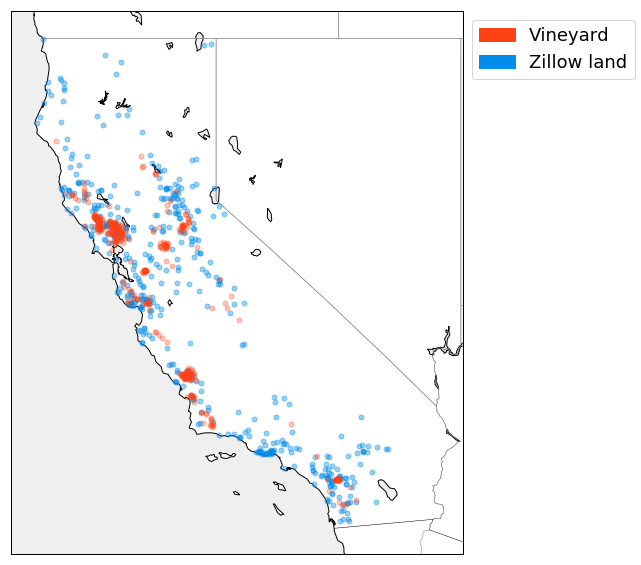

In [226]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap

#Grab all vineyard latitude and longitude values
lats = np.array([i[0] for i in map_coords])
lngs = np.array([i[1] for i in map_coords])

#Filter for vineyards
lat_vineyard = lats[is_vineyard == 1]
lng_vineyard = lngs[is_vineyard == 1]

#Filter for non-vineyards
lat_zillow = lats[is_vineyard == 0].tolist()
lng_zillow = lngs[is_vineyard == 0].tolist()

#Set size of plot
plt.figure(figsize=(12,10))

# Create a base a map of California
my_map = Basemap(projection='merc', 
    resolution = 'i', area_thresh = 50.0,
    llcrnrlon=-125, llcrnrlat=32,
    urcrnrlon=-114, urcrnrlat=42.5)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawstates(color='grey')
my_map.drawmapboundary(fill_color=water_color)
my_map.fillcontinents(color=land_color, lake_color=water_color)

vineyard_x, vineyard_y = my_map(lng_vineyard, lat_vineyard)
zillow_x, zillow_y = my_map(lng_zillow, lat_zillow)
my_map.plot(zillow_x, zillow_y, 'o', color=zillow_color, markersize=5, alpha=0.4)
my_map.plot(vineyard_x, vineyard_y, 'o', color=vineyard_color, markersize=5, alpha=0.3)

plt.legend(bbox_to_anchor=(1, 1), handles=[vineyard_patch, zillow_patch])
plt.show()

## Elevation of vineyards vs non-vineyards (log scale)
Testing to see if there is an elevation sweetspot using elevation height & elevation standard deviation. The plot below, may suggest that extreme heights and elevation variance could be indicative of a non-vineyard, but I don't see a strong correlation. 

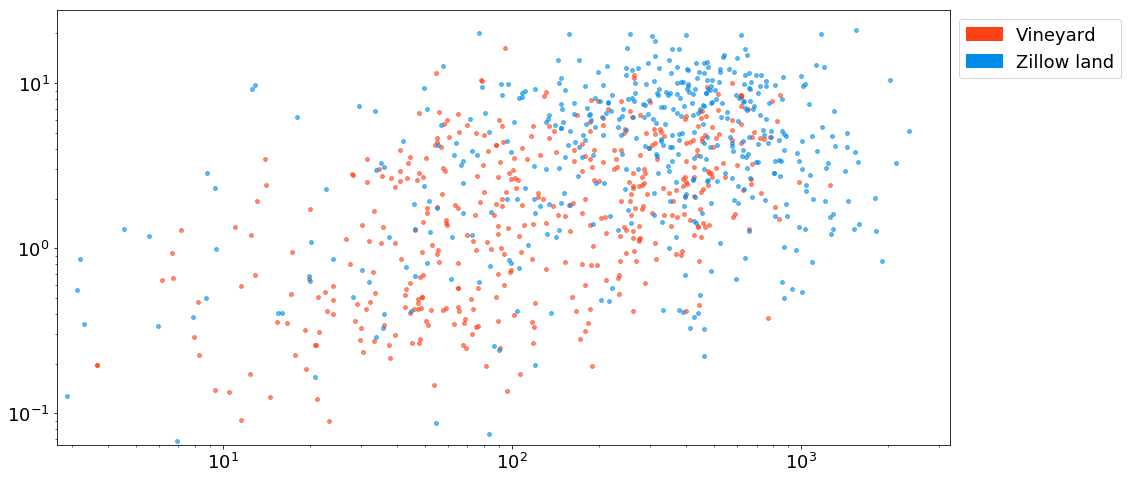

In [129]:
#Get the average elevation for each address
elevation_mean = elevation.mean(axis=(1,2))

#Get the standard deviation for each address
elevation_sd = elevation.std(axis=(1,2))

#Filter for vineyards
elevation_mean_vineyard = elevation_mean[is_vineyard == 1]
elevation_sd_vineyard = elevation_sd[is_vineyard == 1]

#Filter for non-vineyards
elevation_mean_zillow = elevation_mean[is_vineyard == 0]
elevation_sd_zillow = elevation_sd[is_vineyard == 0]

#Set size of plot
plt.figure(figsize=(16,8))

plt.scatter(elevation_mean_vineyard, elevation_sd_vineyard, s=15, c=vineyard_color, alpha=0.6)
plt.scatter(elevation_mean_zillow, elevation_sd_zillow, s=15, c=zillow_color, alpha=0.6)

#Plot at long scale
plt.xscale('log')
plt.yscale('log')

#Custom legend
plt.legend(bbox_to_anchor=(1, 1), handles=[vineyard_patch, zillow_patch])
plt.show()

# Weather time series data
The helper function below creates a list of dates to plot againsts

In [231]:
from datetime import date, datetime, timedelta

def date_series(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

#Create blank date list to append to
date_list = []

for result in date_series(datetime.today() - timedelta(days=350), datetime.today() - timedelta(days=2), timedelta(days=5)):
    date_list.append(result)

## Plotting relative humidity over time
The plot below shows percent of relative humidity for vineyards vs non-vineyards over the past year. It looks like vineyard land has higher relative humidity compared to non-vineyard land in California

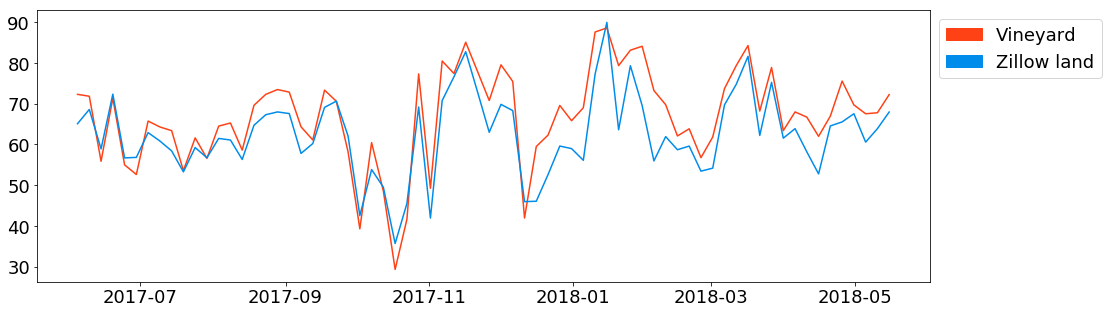

In [246]:
#Filter for vineyards & then take the mean of all vineyard data
rh_vineyard = rh[is_vineyard == 1]
rh_vineyard_mean = np.mean(rh_vineyard, axis=0)

#Filter for non-vineyards & then take the mean of all non-vineyard data
rh_zillow = rh[is_vineyard == 0]
rh_zillow_mean = np.mean(rh_zillow, axis=0)

#Set size of plot
plt.figure(figsize=(16,5))

plt.plot(date_list,rh_vineyard_mean, color=vineyard_color)
plt.plot(date_list,rh_zillow_mean, color=zillow_color)

#Custom legend
plt.legend(bbox_to_anchor=(1, 1), handles=[vineyard_patch, zillow_patch])
plt.show()

## Plotting cloud coverage over time
The plot below shows percent of cloud coverage for vineyards vs non-vineyards over the past year.

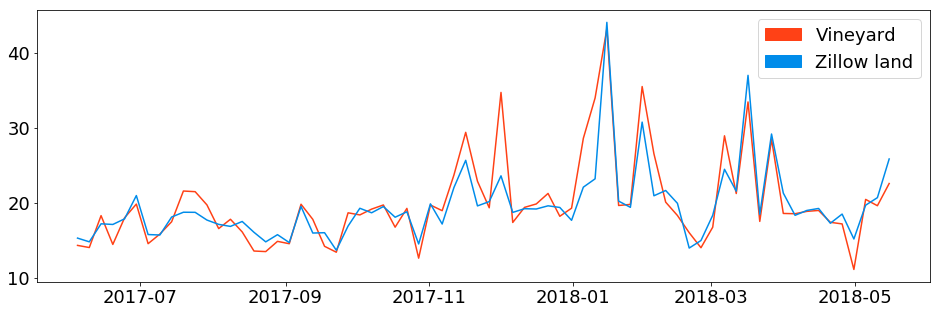

In [245]:
#Filter for vineyards & then take the mean of all vineyard data
clouds_vineyard = clouds[is_vineyard == 1]
clouds_vineyard_mean = np.mean(clouds_vineyard, axis=0)

#Filter for non-vineyards & then take the mean of all non-vineyard data
clouds_zillow = clouds[is_vineyard == 0]
clouds_zillow_mean = np.mean(clouds_zillow, axis=0)

#Set size of plot
plt.figure(figsize=(16,5))

plt.plot(date_list,clouds_vineyard_mean, color=vineyard_color)
plt.plot(date_list,clouds_zillow_mean, color=zillow_color)

#Custom legend
plt.legend(bbox_to_anchor=(1, 1), handles=[vineyard_patch, zillow_patch])
plt.show()

## Plotting minimum temperatures over time 
The plot below shows minimum temperature (Celcius) for vineyards vs non-vineyards over the past year.

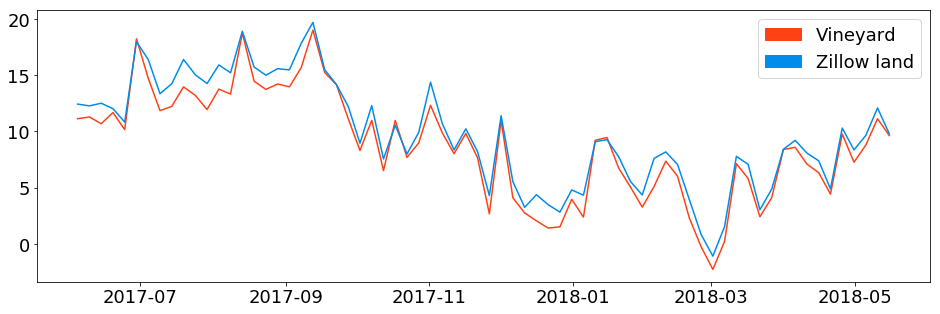

In [237]:
#Filter for vineyards & then take the mean of all vineyard data
min_temp_vineyard = min_temp[is_vineyard == 1]
min_temp_vineyard_mean = np.mean(min_temp_vineyard, axis=0)

#Filter for non-vineyards & then take the mean of all non-vineyard data
min_temp_zillow = min_temp[is_vineyard == 0]
min_temp_zillow_mean = np.mean(min_temp_zillow, axis=0)

#Set size of plot
plt.figure(figsize=(16,5))

plt.plot(date_list,min_temp_vineyard_mean, color=vineyard_color)
plt.plot(date_list,min_temp_zillow_mean, color=zillow_color)

#Custom legend
plt.legend(bbox_to_anchor=(1, 1), handles=[vineyard_patch, zillow_patch])
plt.show()

## Plotting maximum temperatures over time 
The plot below shows maximum temperature (Celcius) for vineyards vs non-vineyards over the past year.

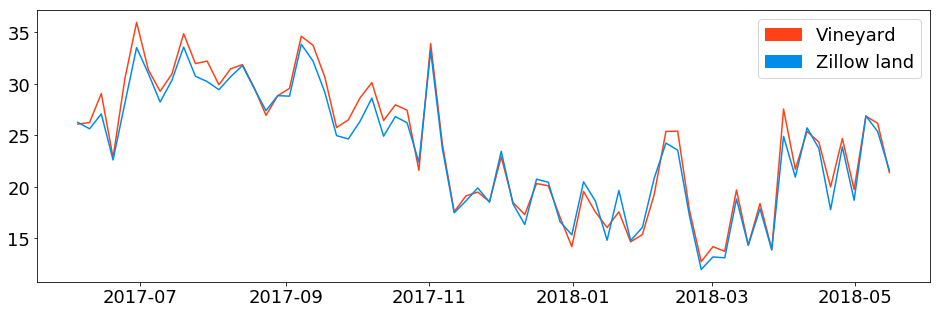

In [238]:
#Filter for vineyards & then take the mean of all vineyard data
max_temp_vineyard = max_temp[is_vineyard == 1]
max_temp_vineyard_mean = np.mean(max_temp_vineyard, axis=0)

#Filter for non-vineyards & then take the mean of all non-vineyard data
max_temp_zillow = max_temp[is_vineyard == 0]
max_temp_zillow_mean = np.mean(max_temp_zillow, axis=0)

#Set size of plot
plt.figure(figsize=(16,5))

plt.plot(date_list,max_temp_vineyard_mean, color=vineyard_color)
plt.plot(date_list,max_temp_zillow_mean, color=zillow_color)

#Custom legend
plt.legend(bbox_to_anchor=(1, 1), handles=[vineyard_patch, zillow_patch])
plt.show()

## Plotting solar radiation over time
The plot below shows Global Horizontal Irradiance (GHI) for vineyards vs non-vineyards over the past year. These look pretty identical which likely means this is a good candidate to drop from our final model.

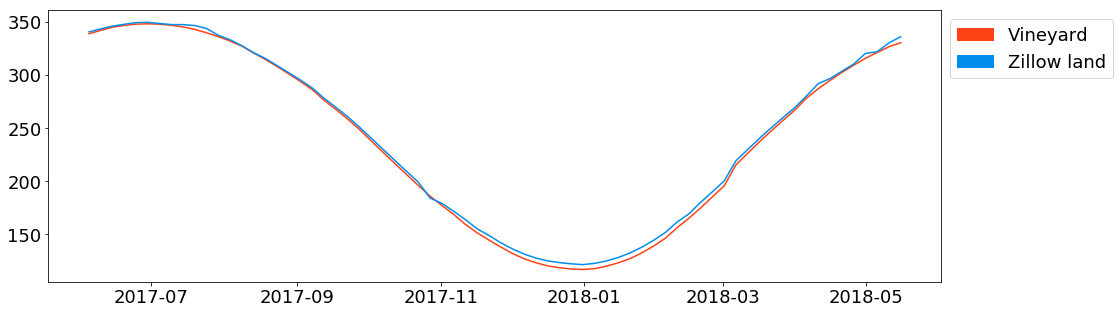

In [239]:
#Filter for vineyards & then take the mean of all vineyard data
ghi_vineyard = ghi[is_vineyard == 1]
ghi_vineyard_mean = np.mean(ghi_vineyard, axis=0)

#Filter for non-vineyards & then take the mean of all non-vineyard data
ghi_zillow = ghi[is_vineyard == 0]
ghi_zillow_mean = np.mean(ghi_zillow, axis=0)

#Set size of plot
plt.figure(figsize=(16,5))

plt.plot(date_list,ghi_vineyard_mean, color=vineyard_color)
plt.plot(date_list,ghi_zillow_mean, color=zillow_color)

#Custom legend
plt.legend(bbox_to_anchor=(1, 1), handles=[vineyard_patch, zillow_patch])
plt.show()

## Plotting precipitation over time 
The plot below shows percipitation (mm) for vineyards vs non-vineyards over the past year.

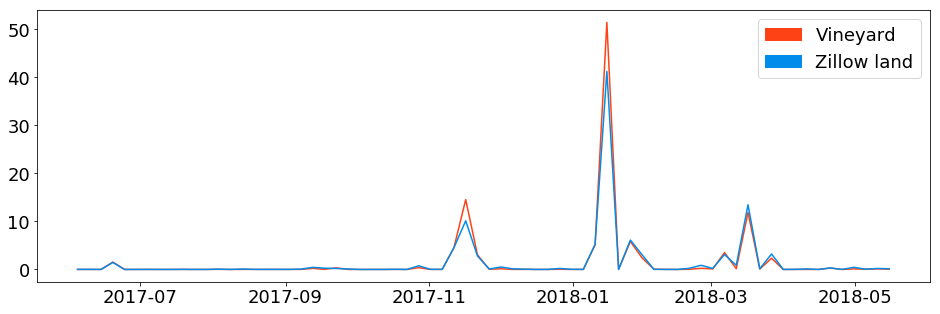

In [244]:
#Filter for vineyards & then take the mean of all vineyard data
precip_vineyard = precip[is_vineyard == 1]
precip_vineyard_mean = np.mean(precip_vineyard, axis=0)

#Filter for non-vineyards & then take the mean of all non-vineyard data
precip_zillow = precip[is_vineyard == 0]
precip_zillow_mean = np.mean(precip_zillow, axis=0)

#Set size of plot
plt.figure(figsize=(16,5))

plt.plot(date_list,precip_vineyard_mean, color=vineyard_color)
plt.plot(date_list,precip_zillow_mean, color=zillow_color)

#Custom legend
plt.legend(bbox_to_anchor=(1, 1), handles=[vineyard_patch, zillow_patch])
plt.show()